#### Benchmaking Experiment 004
- Model : Model4
- Dataset : PAMAP2
- Semantic Space : Glove50
- Cross Validation : 5-fold fixed classes
- Feature Loss : MSELoss

In [1]:
import os 
from datetime import date
from tqdm import tqdm
from copy import deepcopy
import numpy as np 
import pandas as pd

import torch 
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss

from src.datasets.data import PAMAP2Reader
from src.datasets.dataset import PAMAP2Dataset
from src.datasets.utils import load_attribute

from src.models.ts_transformer import *
from src.models.loss import FeatureLoss, AttributeLoss 

from src.utils.analysis import action_evaluator
from src.running import train_step, eval_step

OSError: [WinError 1455] The paging file is too small for this operation to complete. Error loading "c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\torch\lib\shm.dll" or one of its dependencies.

In [ ]:
# setup model configurations
config = {
    # general information
    "experiment-name": "test-001", 
    "datetime": date.today(),
    "device": "gpu",
    "dataset": "PAMAP2",
    "Model": "RelativeGlobalAttention",
    "sem-space": "glove50-v1",
    # model training configs
    "include_attribute_loss": True, 
    "semantic_size": 64,
    "n_actions": 18,
    "folding": True,
    "fold_classes": [['watching TV', 'house cleaning', 'standing', 'ascending stairs'], ['walking', 'rope jumping', 'sitting', 'descending stairs'], ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'], ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']],
    "lr": 0.001,
    "n_epochs": 10,
    "optimizer": "adam",
    "batch_size": 32,
    "semantic_loss": "cosine_distance",
    # model configs
    "d_model": 128, 
    "num_heads": 2,
    "dim_feedforward": 128,
    "num_layers": 2,
    "pos_encoding": 'fixed',
    "activation": 'relu',
    "norm": "BatchNorm",
    # dataset configs
    "window_size": 5, 
    "overlap": 0.5,
    "seq_len": 200,
    "seen_split": 0.2,
    "unseen_split": 0.8
}

---
Model Building

In [ ]:
class Model8(nn.Module):
    def __init__(self, in_ft, d_model, num_heads, num_layers, dim_feedforward, ft_size,
                pos_encoding='fixed', activation='gelu', norm='BatchNorm', max_len=1024, dropout=0.1, freeze=False):
        super(Model8, self).__init__()
        self.in_ft = in_ft
        self.max_len = max_len
        self.d_model = d_model
        self.num_heads = num_heads
        self.ft_size = ft_size 

        # feature prep layer
        self.DenseL = nn.Linear(in_ft, d_model)
        self.pos_enc = get_pos_encoder(pos_encoding)(d_model, dropout=dropout*(1.0 - freeze), max_len=max_len)
        # relative global attention layer
        if norm == 'LayerNorm':
            encoder_layer = TransformerEncoderLayer(d_model, self.num_heads, dim_feedforward, dropout*(1.0 - freeze), activation=activation)
        else:
            encoder_layer = TransformerBatchNormEncoderLayer(d_model, self.num_heads, dim_feedforward, dropout*(1.0 - freeze), activation=activation)

        self.AttnL = nn.TransformerEncoder(encoder_layer, num_layers)

        # positional encoding concat <-> LSTM 
        self.lstmL = nn.LSTM(input_size=d_model, hidden_size=ft_size, batch_first=True)
        self.DensePostL = nn.Linear(in_features=ft_size, out_features=ft_size)

    def forward(self, x):
        x = x.permute(1,0,2)
        out = self.DenseL(x)
        out = self.pos_enc(out)* math.sqrt(self.d_model)
        out = self.AttnL(out)
        out = out.permute(1,0,2)
        lstm_out, hidden = self.lstmL(out)
        out = self.DensePostL(lstm_out[:, -1, :])
        return out
    

---

In [ ]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# import PAMAP2 dataset
dataReader = PAMAP2Reader('./data/PAMAP2_Dataset/Protocol/')
actionList = dataReader.idToLabel

Reading file 1 of 14
Reading file 2 of 14
Reading file 3 of 14
Reading file 4 of 14
Reading file 5 of 14
Reading file 6 of 14
Reading file 7 of 14
Reading file 8 of 14
Reading file 9 of 14
Reading file 10 of 14
Reading file 11 of 14
Reading file 12 of 14
Reading file 13 of 14
Reading file 14 of 14


g:\FYP\Codebases\HAR-ZSL-XAI\src\datasets\data.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(data), np.asarray(labels, dtype=int), np.array(collection)


In [ ]:
# import PAMAP2 attributes
activity_dict, attribute_dict, attr_mat = load_attribute('./data/PAMAP2_Dataset/PAMAP2_attributes.json')
_, attr_size = attr_mat.shape

In [ ]:
# Load semantic feature space 
st = config['sem-space']
if st == 'glove50-v1':
    fpath = './data/PAMAP2_Dataset/glove_features.npy'
elif st == 'glove50-v2':
    fpath = './data/PAMAP2_Dataset/glove_featureV2.npy'
elif st == 'video-V1':
    fpath = './data/PAMAP2_Dataset/video_pca_ft.npy'

feat_mat = np.load(fpath)
n_actions, feat_size = feat_mat.shape

In [ ]:
# run 5-fold running
fold_classes = config['fold_classes']
fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

================ Fold-0 ================
Unseen Classes : ['watching TV', 'house cleaning', 'standing', 'ascending stairs']


eval: 100%|██████████| 26/26 [00:01<00:00, 21.25batch/s, loss=0.195]


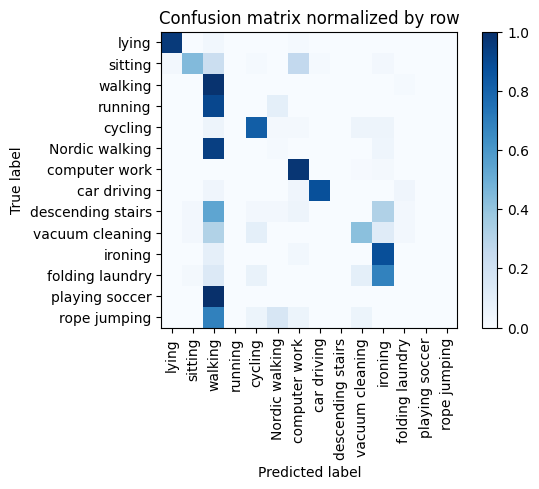

Training Epoch:  10%|█         | 1/10 [00:12<01:50, 12.32s/it]

Overall accuracy: 0.578



eval: 100%|██████████| 26/26 [00:01<00:00, 21.28batch/s, loss=0.163]


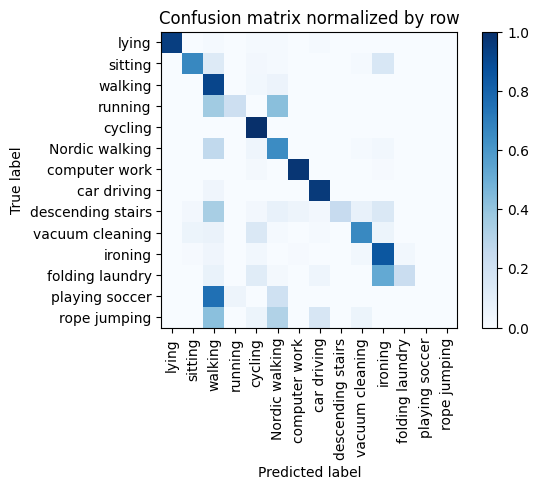

Training Epoch:  20%|██        | 2/10 [00:25<01:41, 12.64s/it]

Overall accuracy: 0.712



eval: 100%|██████████| 26/26 [00:01<00:00, 19.61batch/s, loss=0.0568]


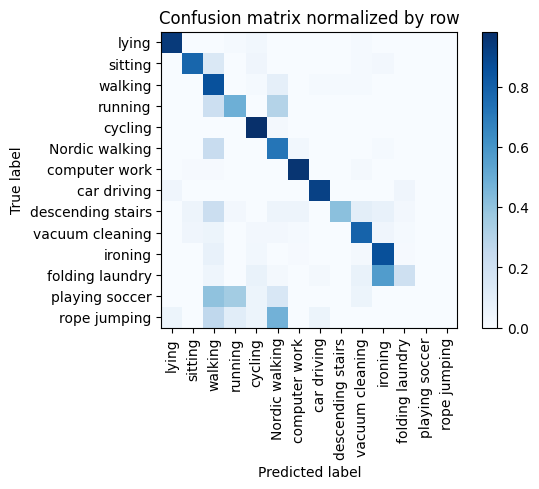

Training Epoch:  30%|███       | 3/10 [00:37<01:27, 12.49s/it]

Overall accuracy: 0.752



eval: 100%|██████████| 26/26 [00:00<00:00, 37.82batch/s, loss=0.103]


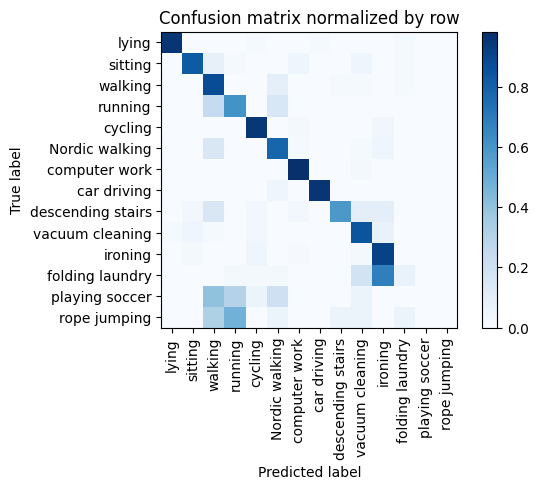

Training Epoch:  40%|████      | 4/10 [00:43<01:00, 10.11s/it]

Overall accuracy: 0.782



eval: 100%|██████████| 26/26 [00:00<00:00, 58.30batch/s, loss=0.123]


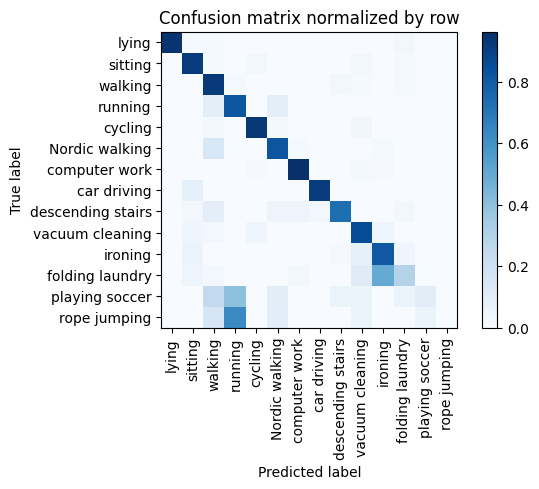

Training Epoch:  50%|█████     | 5/10 [00:48<00:40,  8.18s/it]

Overall accuracy: 0.813



eval: 100%|██████████| 26/26 [00:00<00:00, 52.52batch/s, loss=0.0301]


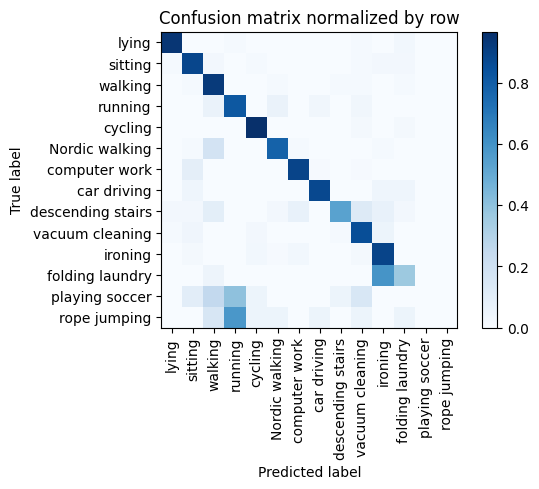

Training Epoch:  60%|██████    | 6/10 [00:52<00:27,  6.77s/it]

Overall accuracy: 0.799



eval: 100%|██████████| 26/26 [00:00<00:00, 61.18batch/s, loss=0.0776]


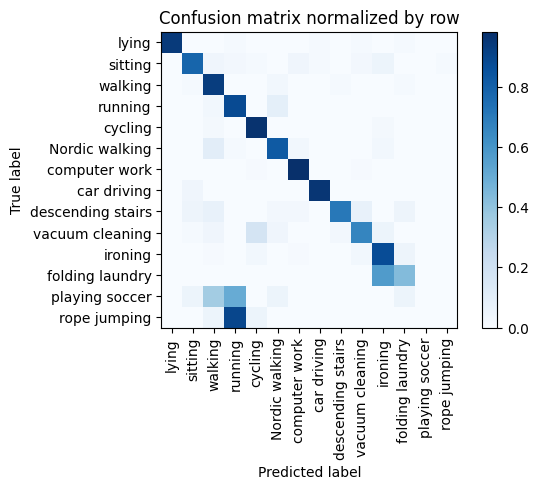

Training Epoch:  70%|███████   | 7/10 [00:56<00:17,  5.77s/it]

Overall accuracy: 0.801



eval: 100%|██████████| 26/26 [00:00<00:00, 63.57batch/s, loss=0.13]


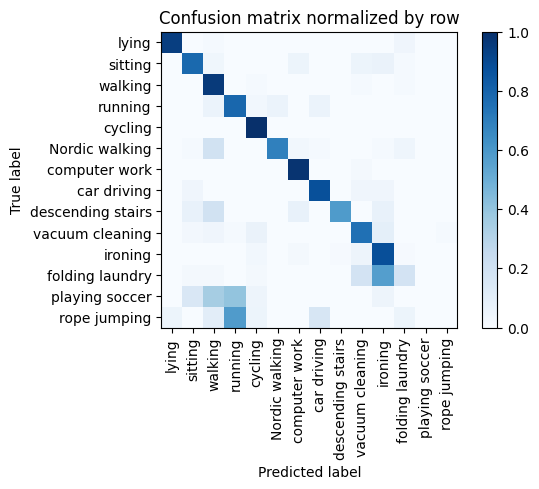

Training Epoch:  80%|████████  | 8/10 [00:59<00:10,  5.06s/it]

Overall accuracy: 0.779



eval: 100%|██████████| 26/26 [00:00<00:00, 63.52batch/s, loss=0.0902]


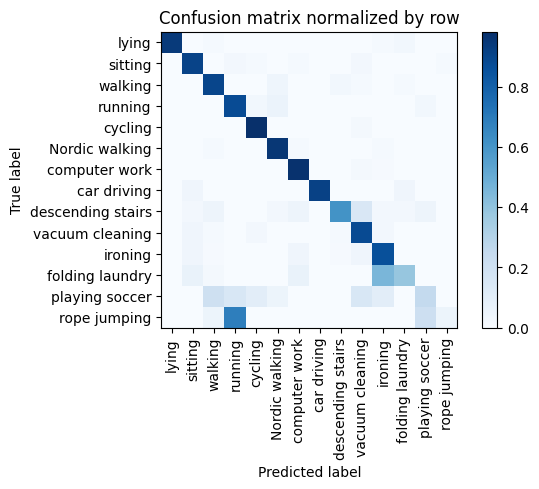

Training Epoch:  90%|█████████ | 9/10 [01:03<00:04,  4.57s/it]

Overall accuracy: 0.840



eval: 100%|██████████| 26/26 [00:00<00:00, 63.73batch/s, loss=0.0874]


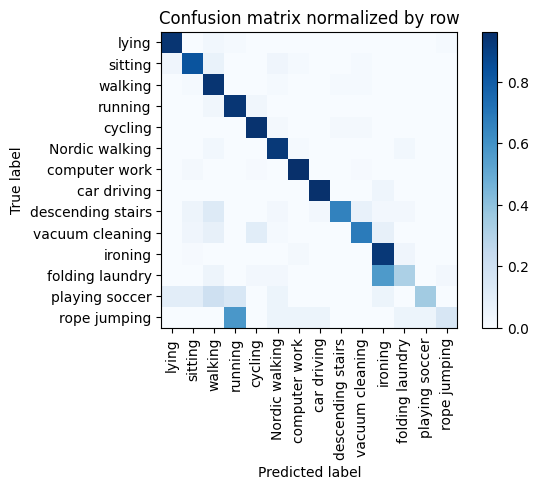

Overall accuracy: 0.828



eval: 100%|██████████| 28/28 [00:00<00:00, 83.70batch/s, loss=0.45] 


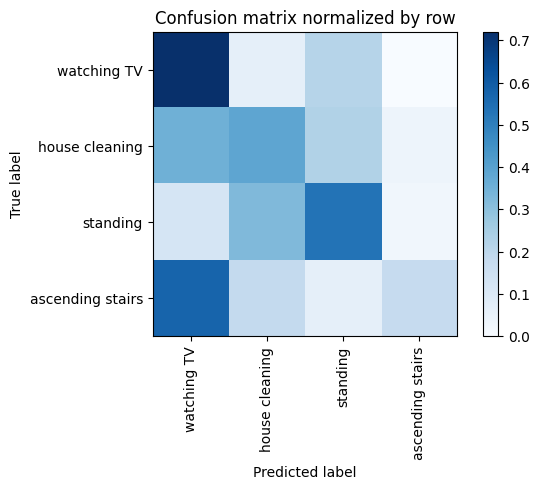

Overall accuracy: 0.442

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        standing       0.605      0.532      0.566      0.334        293|	 house cleaning: 0.321,	watching TV: 0.123,	
  house cleaning       0.451      0.387      0.417      0.324        284|	 watching TV: 0.352,	standing: 0.225,	
ascending stairs       0.646      0.178      0.279      0.199        174|	 watching TV: 0.575,	house cleaning: 0.184,	
     watching TV       0.276      0.720      0.399      0.143        125|	 standing: 0.216,	house cleaning: 0.064,	

----------------------------------------------------------------------------------------------------
     avg / total       0.516      0.442      0.437        1.0        876|	      

{'total_accuracy': 0.4417808219178082, 'precision': 0.49434444697177016, 'recall': 0.45447701784833194, 'f1': 0.4153255555445587}
================ Fold-1 ================
Unseen Classes : ['walking', 'rope jumping', 'sitting', 'desc

eval: 100%|██████████| 26/26 [00:00<00:00, 62.65batch/s, loss=0.177]


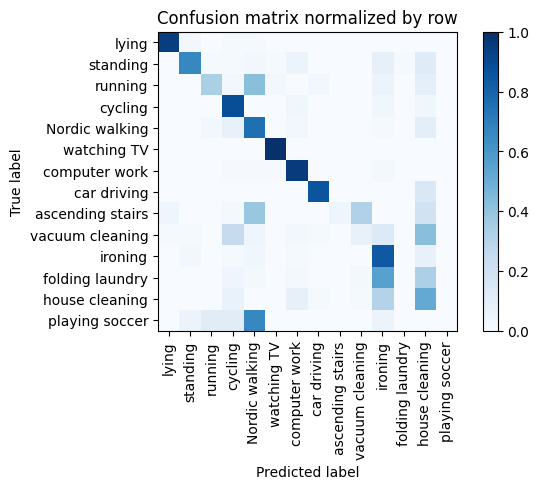

Training Epoch:  10%|█         | 1/10 [00:04<00:36,  4.08s/it]

Overall accuracy: 0.631



eval: 100%|██████████| 26/26 [00:00<00:00, 65.82batch/s, loss=0.1]


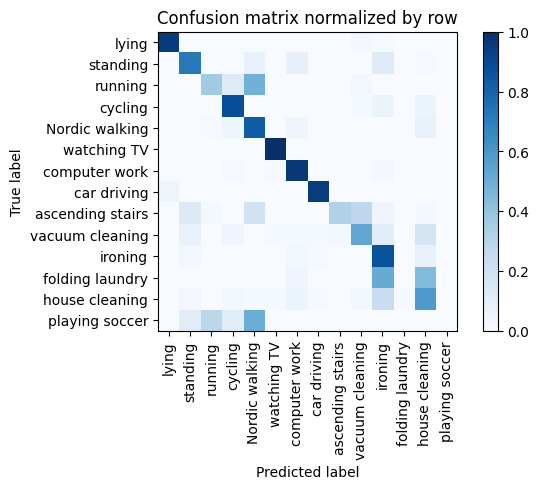

Training Epoch:  20%|██        | 2/10 [00:07<00:30,  3.76s/it]

Overall accuracy: 0.710



eval: 100%|██████████| 26/26 [00:00<00:00, 47.48batch/s, loss=0.192]


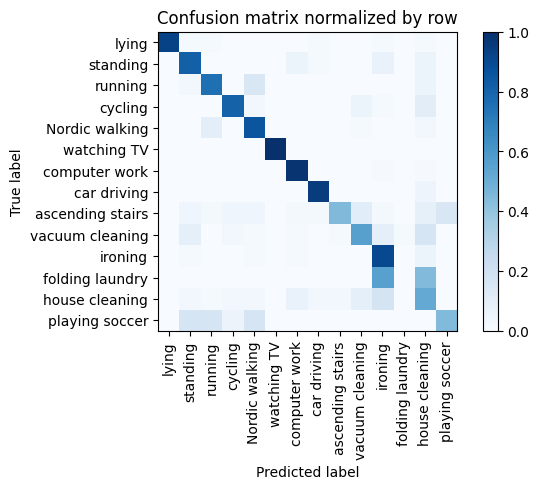

Training Epoch:  30%|███       | 3/10 [00:11<00:26,  3.74s/it]

Overall accuracy: 0.746



eval: 100%|██████████| 26/26 [00:00<00:00, 60.18batch/s, loss=0.122]


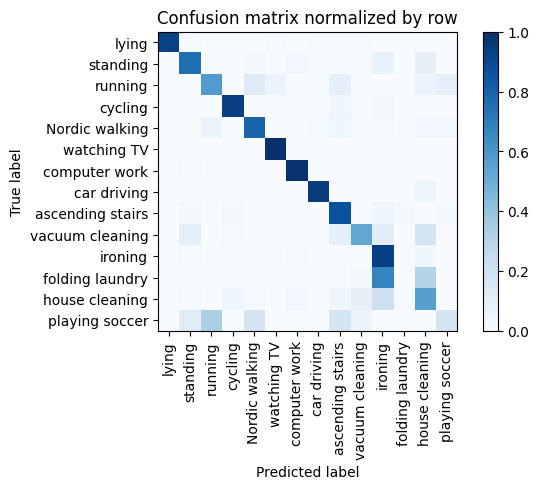

Training Epoch:  40%|████      | 4/10 [00:14<00:21,  3.66s/it]

Overall accuracy: 0.766



eval: 100%|██████████| 26/26 [00:00<00:00, 63.26batch/s, loss=0.0783]


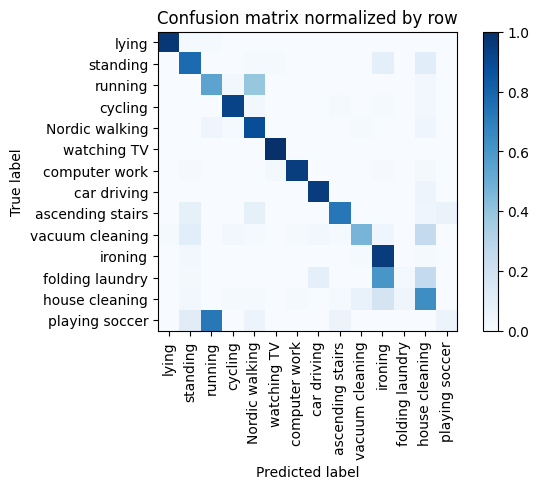

Training Epoch:  50%|█████     | 5/10 [00:18<00:17,  3.60s/it]

Overall accuracy: 0.763



eval: 100%|██████████| 26/26 [00:00<00:00, 64.59batch/s, loss=0.137]


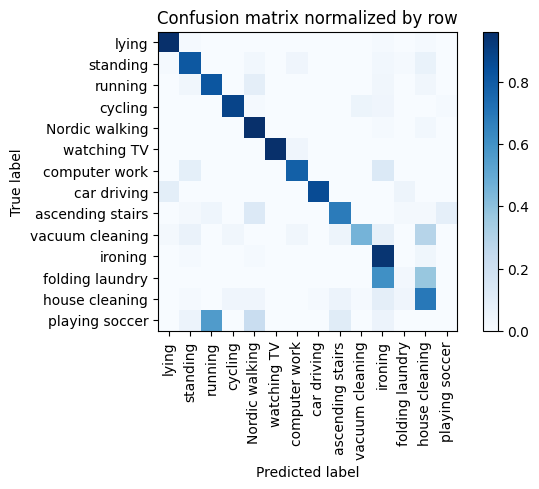

Training Epoch:  60%|██████    | 6/10 [00:21<00:14,  3.58s/it]

Overall accuracy: 0.751



eval: 100%|██████████| 26/26 [00:00<00:00, 63.98batch/s, loss=0.0351]


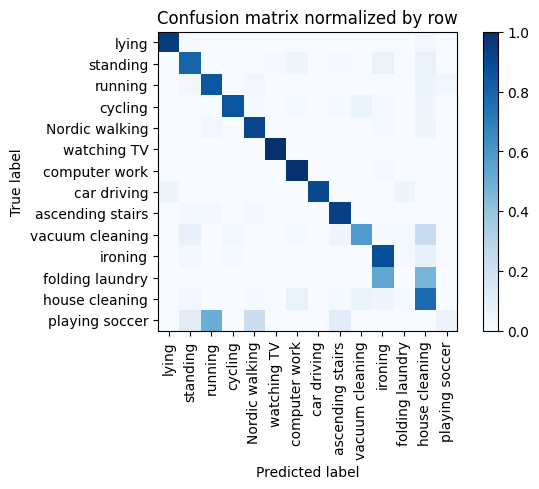

Training Epoch:  70%|███████   | 7/10 [00:25<00:10,  3.59s/it]

Overall accuracy: 0.803



eval: 100%|██████████| 26/26 [00:00<00:00, 59.91batch/s, loss=0.1]


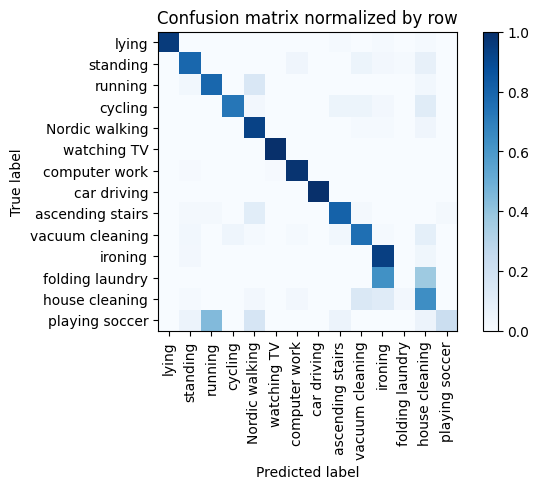

Training Epoch:  80%|████████  | 8/10 [00:29<00:07,  3.62s/it]

Overall accuracy: 0.794



eval: 100%|██████████| 26/26 [00:00<00:00, 46.43batch/s, loss=0.0674]


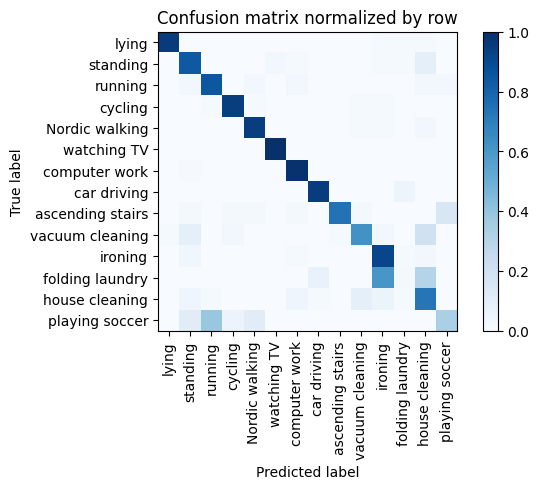

Training Epoch:  90%|█████████ | 9/10 [00:33<00:03,  3.97s/it]

Overall accuracy: 0.819



eval: 100%|██████████| 26/26 [00:00<00:00, 50.00batch/s, loss=0.0626]


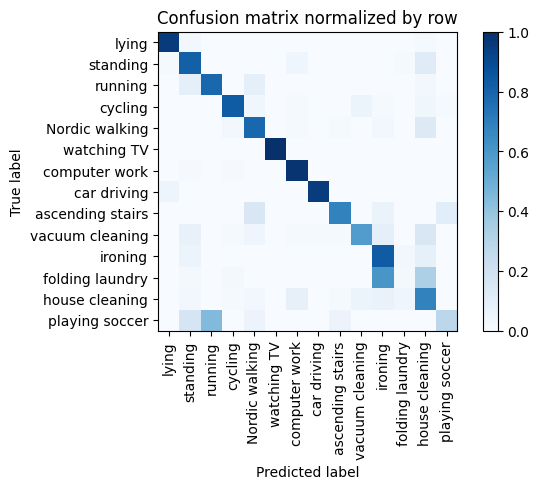

Overall accuracy: 0.766



eval: 100%|██████████| 28/28 [00:00<00:00, 74.07batch/s, loss=0.369]


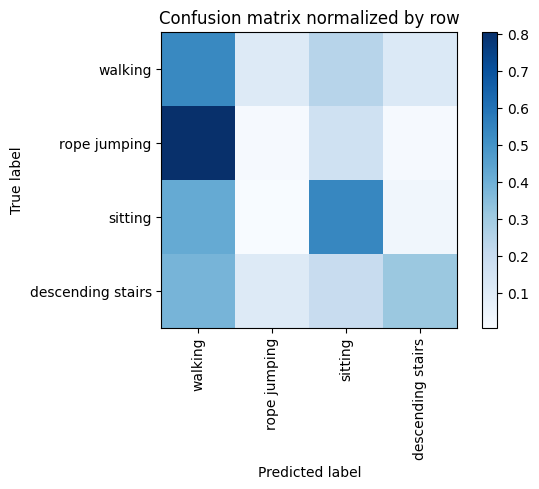

Overall accuracy: 0.452

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          walking       0.456      0.531      0.491      0.423        369|	 sitting: 0.244,	descending stairs: 0.117,	
          sitting       0.532      0.540      0.536      0.318        278|	 walking: 0.421,	descending stairs: 0.032,	
descending stairs       0.475      0.312      0.376      0.176        154|	 walking: 0.383,	sitting: 0.195,	
     rope jumping       0.017      0.014      0.015      0.082         72|	 walking: 0.806,	sitting: 0.167,	descending stairs: 0.014,	

----------------------------------------------------------------------------------------------------
      avg / total       0.447      0.452      0.446        1.0        873|	      

{'total_accuracy': 0.4524627720504009, 'precision': 0.36991075963113385, 'recall': 0.34907771438851454, 'f1': 0.354487413921081}
================ Fold-2 ================
Unseen Classes : ['playing soccer', 'lying', 

eval: 100%|██████████| 24/24 [00:00<00:00, 52.22batch/s, loss=0.216]


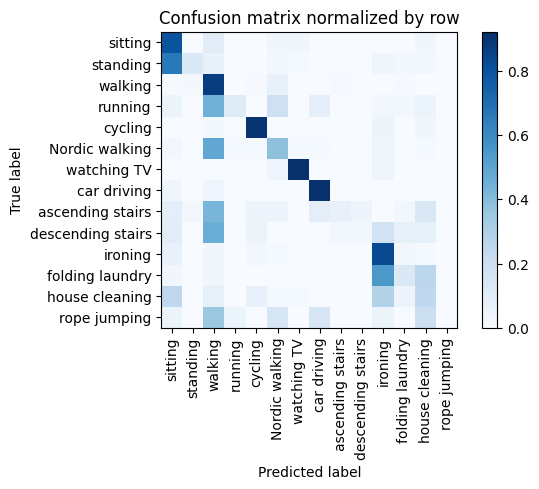

Training Epoch:  10%|█         | 1/10 [00:04<00:36,  4.09s/it]

Overall accuracy: 0.505



eval: 100%|██████████| 24/24 [00:00<00:00, 55.94batch/s, loss=0.137]


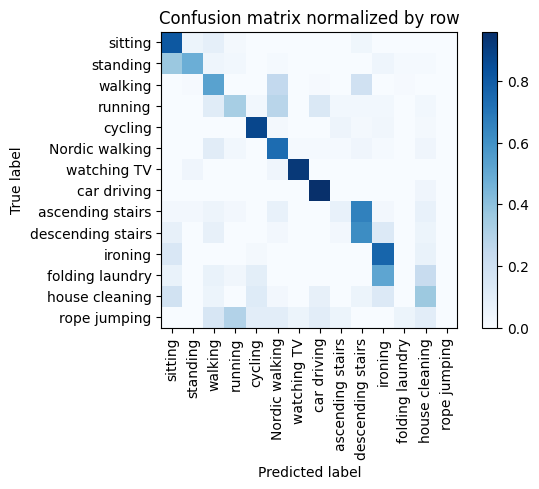

Training Epoch:  20%|██        | 2/10 [00:07<00:31,  3.97s/it]

Overall accuracy: 0.569



eval: 100%|██████████| 24/24 [00:00<00:00, 58.25batch/s, loss=0.114]


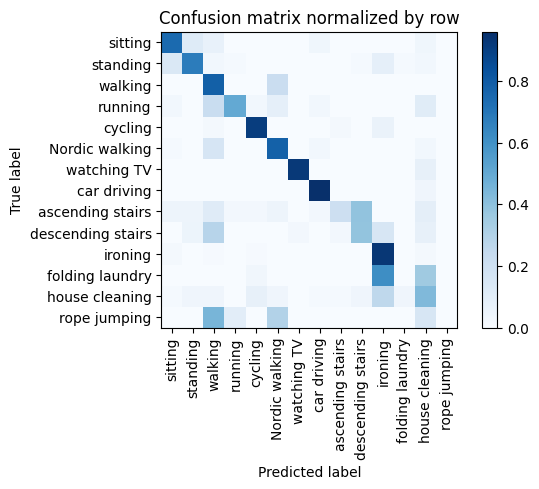

Training Epoch:  30%|███       | 3/10 [00:12<00:29,  4.15s/it]

Overall accuracy: 0.652



eval: 100%|██████████| 24/24 [00:00<00:00, 64.69batch/s, loss=0.132]


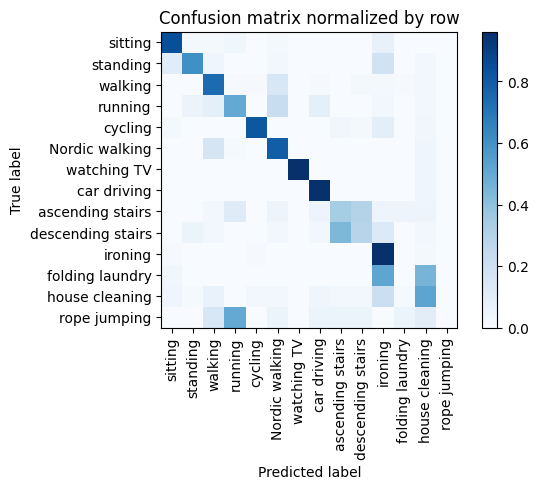

Training Epoch:  40%|████      | 4/10 [00:15<00:23,  3.89s/it]

Overall accuracy: 0.657



eval: 100%|██████████| 24/24 [00:00<00:00, 48.48batch/s, loss=0.101]


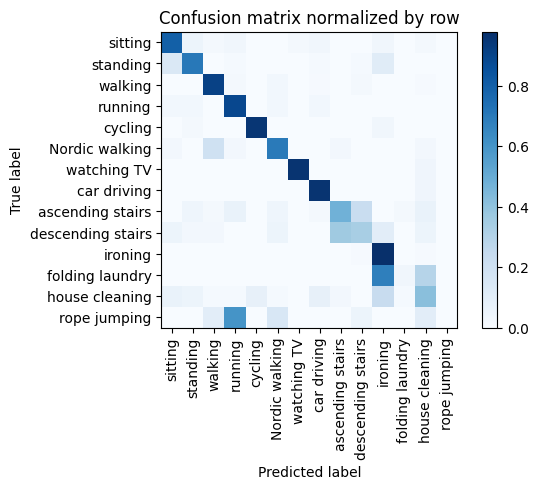

Training Epoch:  50%|█████     | 5/10 [00:20<00:21,  4.26s/it]

Overall accuracy: 0.710



eval: 100%|██████████| 24/24 [00:00<00:00, 48.19batch/s, loss=0.114]


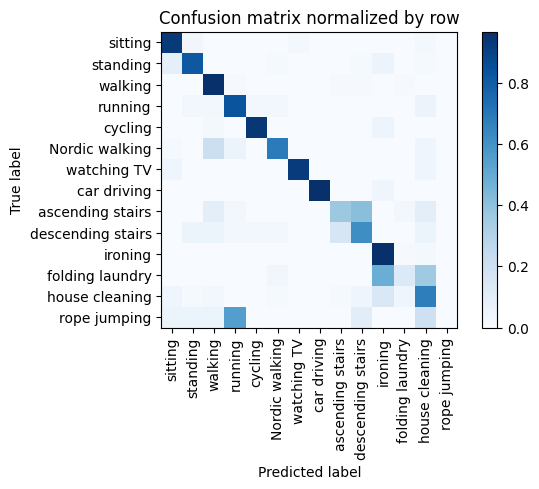

Training Epoch:  60%|██████    | 6/10 [00:25<00:18,  4.52s/it]

Overall accuracy: 0.768



eval: 100%|██████████| 24/24 [00:00<00:00, 42.33batch/s, loss=0.128]


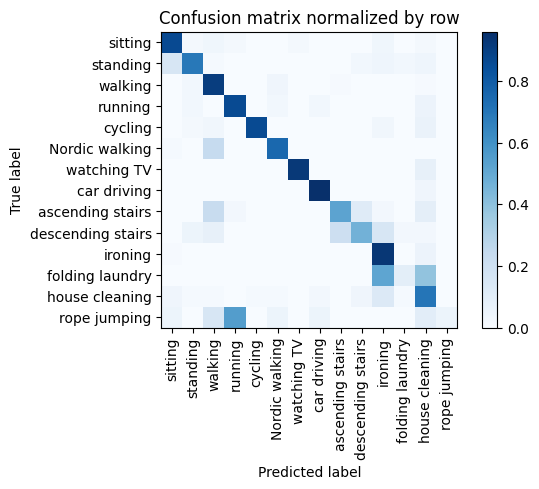

Training Epoch:  70%|███████   | 7/10 [00:31<00:14,  4.85s/it]

Overall accuracy: 0.745



eval: 100%|██████████| 24/24 [00:00<00:00, 59.41batch/s, loss=0.124]


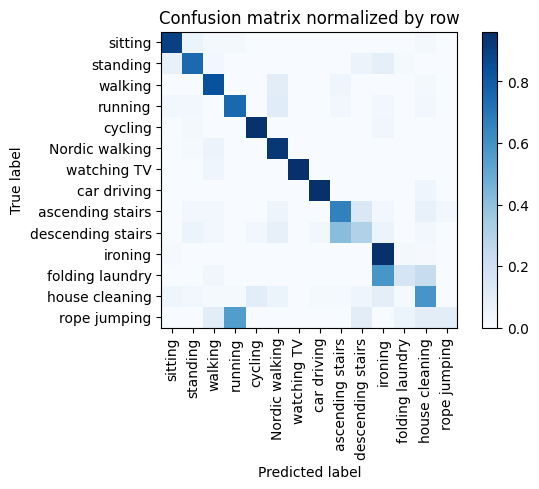

Training Epoch:  80%|████████  | 8/10 [00:35<00:09,  4.78s/it]

Overall accuracy: 0.761



eval: 100%|██████████| 24/24 [00:00<00:00, 64.69batch/s, loss=0.125]


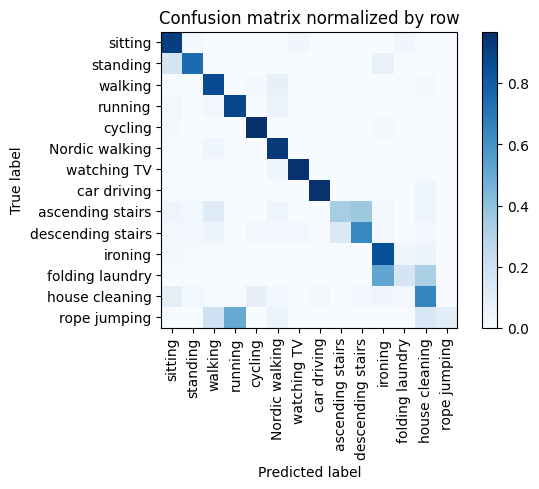

Training Epoch:  90%|█████████ | 9/10 [00:39<00:04,  4.34s/it]

Overall accuracy: 0.768



eval: 100%|██████████| 24/24 [00:00<00:00, 60.61batch/s, loss=0.0978]


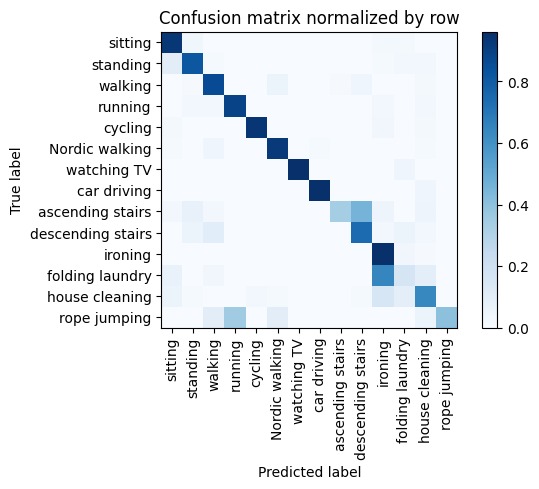

Overall accuracy: 0.794



eval: 100%|██████████| 35/35 [00:00<00:00, 67.70batch/s, loss=0.442]


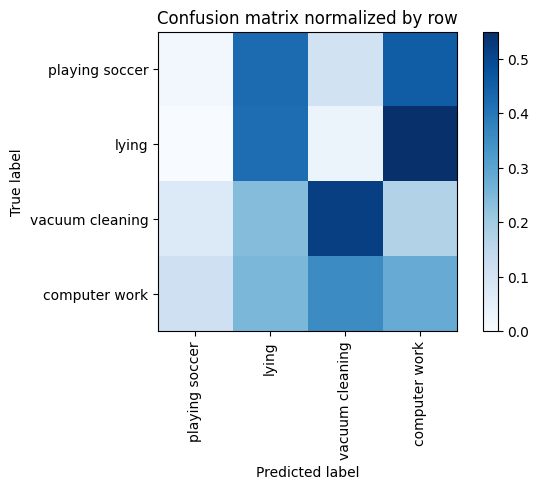

Overall accuracy: 0.360

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

  computer work       0.352      0.280      0.312      0.424        468|	 vacuum cleaning: 0.355,	lying: 0.252,	
          lying       0.374      0.420      0.396      0.271        300|	 computer work: 0.550,	vacuum cleaning: 0.030,	
vacuum cleaning       0.435      0.517      0.472      0.245        271|	 lying: 0.240,	computer work: 0.170,	
 playing soccer       0.014      0.015      0.014      0.060         66|	 computer work: 0.455,	lying: 0.424,	vacuum cleaning: 0.106,	

----------------------------------------------------------------------------------------------------
    avg / total       0.358      0.360      0.356        1.0       1105|	      

{'total_accuracy': 0.3601809954751131, 'precision': 0.29358347504991433, 'recall': 0.3079178027794264, 'f1': 0.298492562805379}
================ Fold-3 ================
Unseen Classes : ['cycling', 'running', 'Nordic walk

eval: 100%|██████████| 27/27 [00:00<00:00, 63.83batch/s, loss=0.148]


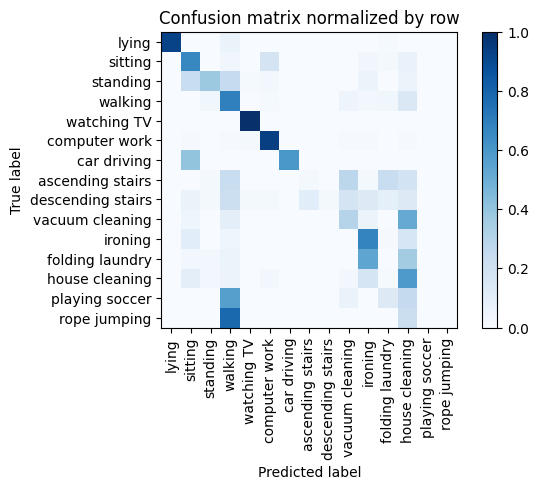

Training Epoch:  10%|█         | 1/10 [00:03<00:34,  3.79s/it]

Overall accuracy: 0.554



eval: 100%|██████████| 27/27 [00:00<00:00, 63.83batch/s, loss=0.13]


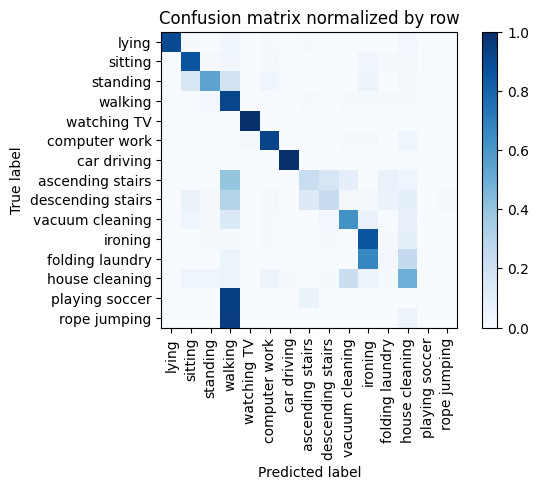

Training Epoch:  20%|██        | 2/10 [00:07<00:31,  3.90s/it]

Overall accuracy: 0.670



eval: 100%|██████████| 27/27 [00:00<00:00, 65.06batch/s, loss=0.121]


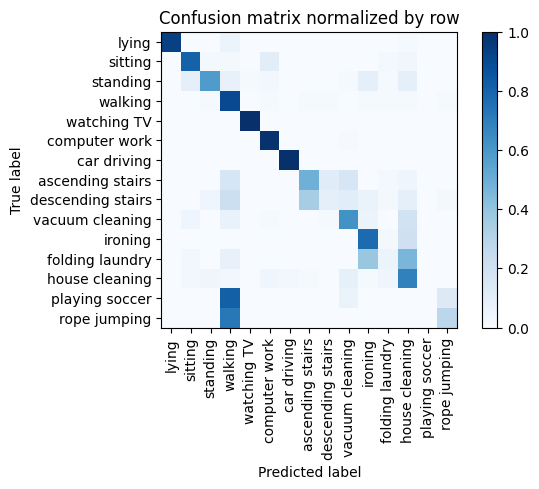

Training Epoch:  30%|███       | 3/10 [00:12<00:28,  4.12s/it]

Overall accuracy: 0.700



eval: 100%|██████████| 27/27 [00:00<00:00, 67.67batch/s, loss=0.0994]


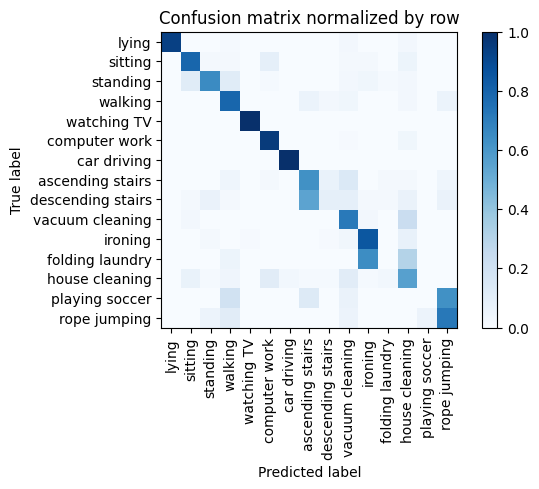

Training Epoch:  40%|████      | 4/10 [00:16<00:24,  4.05s/it]

Overall accuracy: 0.709



eval: 100%|██████████| 27/27 [00:00<00:00, 66.02batch/s, loss=0.0796]


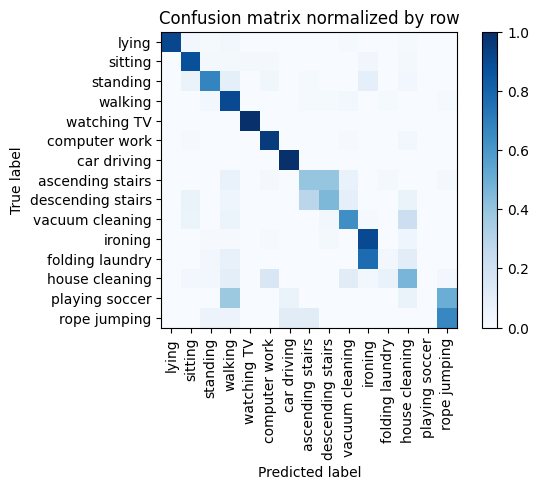

Training Epoch:  50%|█████     | 5/10 [00:19<00:19,  3.97s/it]

Overall accuracy: 0.724



eval: 100%|██████████| 27/27 [00:00<00:00, 65.53batch/s, loss=0.0886]


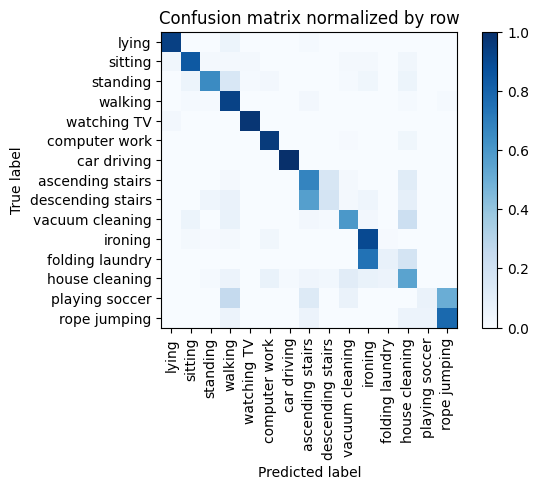

Training Epoch:  60%|██████    | 6/10 [00:23<00:15,  3.89s/it]

Overall accuracy: 0.731



eval: 100%|██████████| 27/27 [00:00<00:00, 64.13batch/s, loss=0.0911]


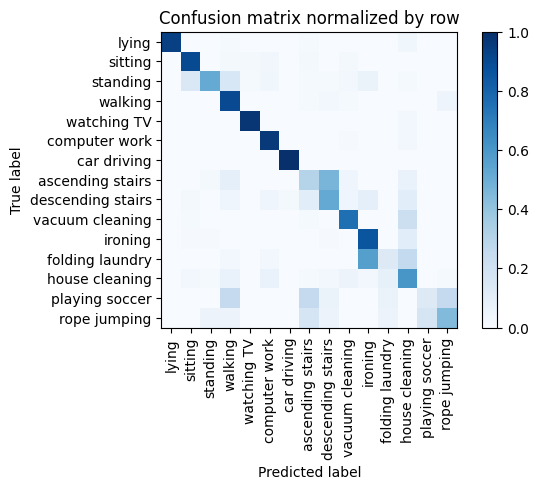

Training Epoch:  70%|███████   | 7/10 [00:27<00:11,  3.86s/it]

Overall accuracy: 0.732



eval: 100%|██████████| 27/27 [00:00<00:00, 61.78batch/s, loss=0.0625]


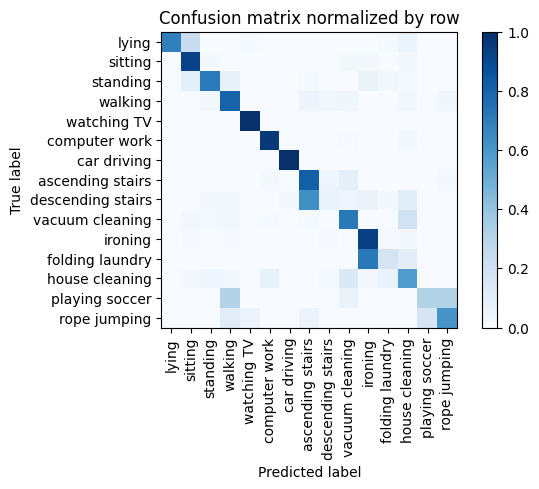

Training Epoch:  80%|████████  | 8/10 [00:31<00:07,  3.85s/it]

Overall accuracy: 0.735



eval: 100%|██████████| 27/27 [00:00<00:00, 66.18batch/s, loss=0.116]


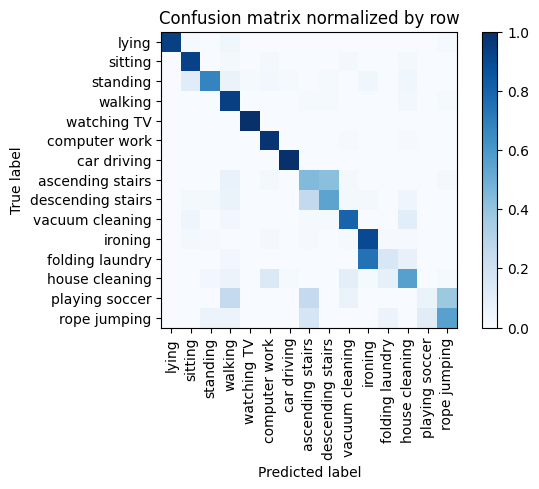

Training Epoch:  90%|█████████ | 9/10 [00:35<00:03,  3.84s/it]

Overall accuracy: 0.771



eval: 100%|██████████| 27/27 [00:00<00:00, 66.83batch/s, loss=0.0675]


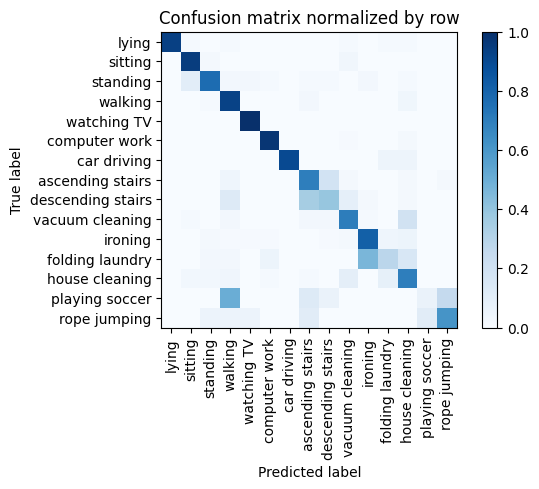

Overall accuracy: 0.781



eval: 100%|██████████| 22/22 [00:00<00:00, 73.83batch/s, loss=0.62] 


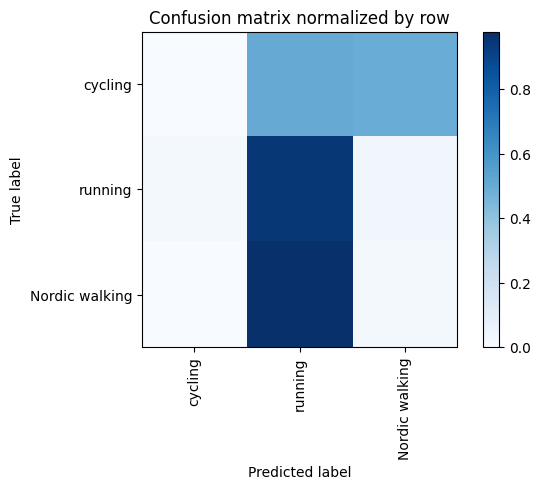

Overall accuracy: 0.222

                 precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Nordic walking       0.037      0.018      0.024      0.406        278|	 running: 0.978,	cycling: 0.004,	
       cycling       0.000      0.000      0.000      0.368        252|	 running: 0.504,	Nordic walking: 0.496,	
       running       0.269      0.948      0.419      0.226        155|	 Nordic walking: 0.032,	cycling: 0.019,	

----------------------------------------------------------------------------------------------------
   avg / total       0.076      0.222      0.105        1.0        685|	      

{'total_accuracy': 0.22189781021897811, 'precision': 0.10208926875593542, 'recall': 0.32212423609499496, 'f1': 0.14787131032688225}
================ Fold-4 ================
Unseen Classes : ['ironing', 'car driving', 'folding laundry']


eval: 100%|██████████| 28/28 [00:00<00:00, 66.35batch/s, loss=0.211]


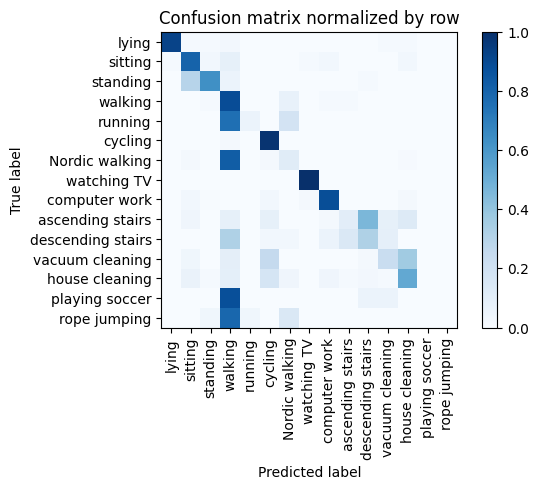

Training Epoch:  10%|█         | 1/10 [00:03<00:34,  3.84s/it]

Overall accuracy: 0.589



eval: 100%|██████████| 28/28 [00:00<00:00, 58.95batch/s, loss=0.145]


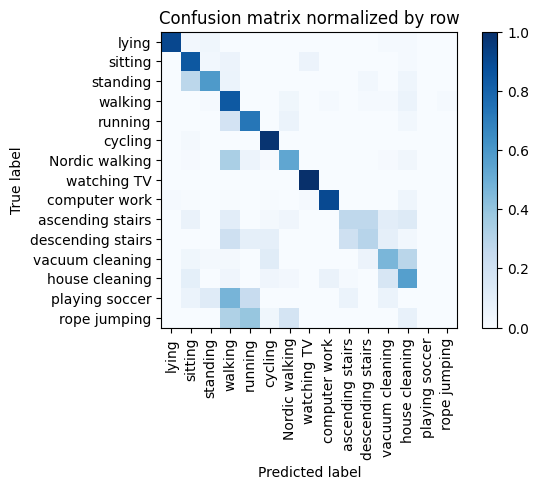

Training Epoch:  20%|██        | 2/10 [00:08<00:32,  4.08s/it]

Overall accuracy: 0.676



eval: 100%|██████████| 28/28 [00:00<00:00, 64.81batch/s, loss=0.123]


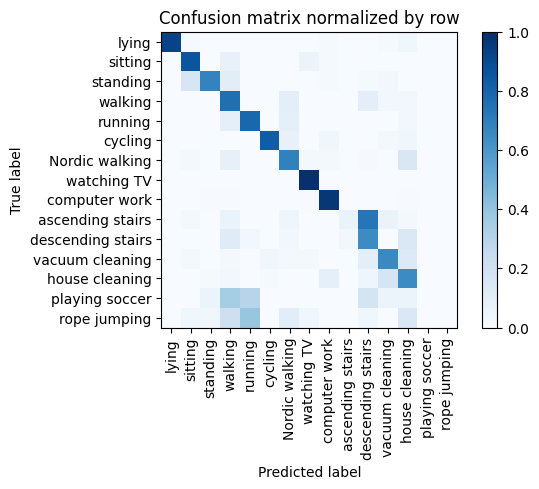

Training Epoch:  30%|███       | 3/10 [00:12<00:28,  4.02s/it]

Overall accuracy: 0.715



eval: 100%|██████████| 28/28 [00:00<00:00, 62.08batch/s, loss=0.16]


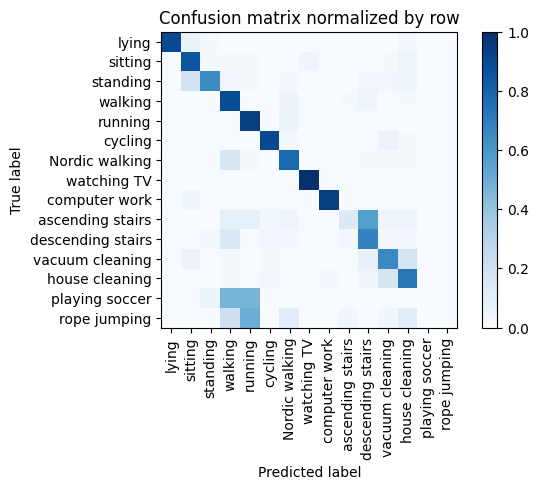

Training Epoch:  40%|████      | 4/10 [00:15<00:23,  3.98s/it]

Overall accuracy: 0.749



eval: 100%|██████████| 28/28 [00:00<00:00, 64.32batch/s, loss=0.18]


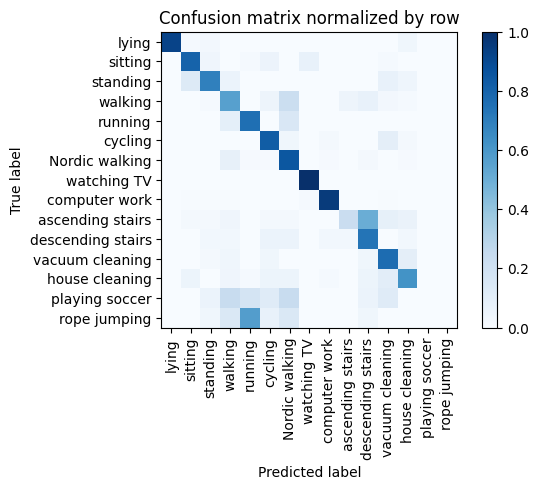

Training Epoch:  50%|█████     | 5/10 [00:19<00:19,  3.95s/it]

Overall accuracy: 0.723



eval: 100%|██████████| 28/28 [00:00<00:00, 62.50batch/s, loss=0.0577]


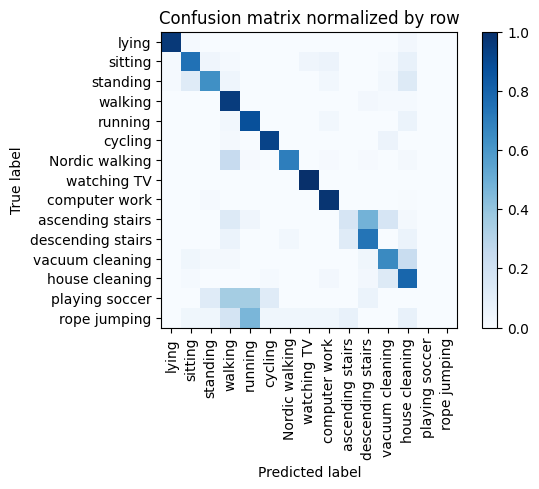

Training Epoch:  60%|██████    | 6/10 [00:23<00:15,  3.94s/it]

Overall accuracy: 0.757



eval: 100%|██████████| 28/28 [00:00<00:00, 68.29batch/s, loss=0.126]


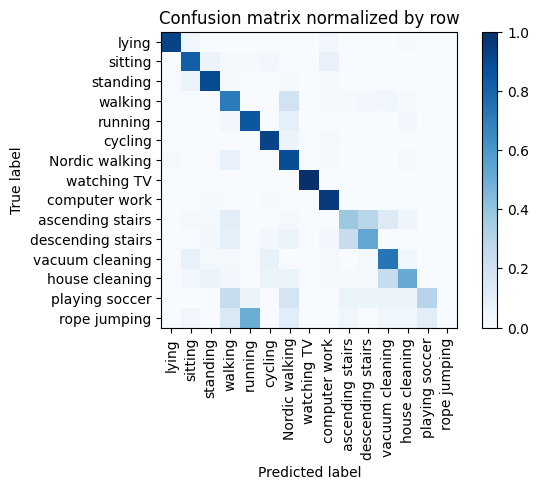

Training Epoch:  70%|███████   | 7/10 [00:27<00:11,  3.92s/it]

Overall accuracy: 0.760



eval: 100%|██████████| 28/28 [00:00<00:00, 65.57batch/s, loss=0.0571]


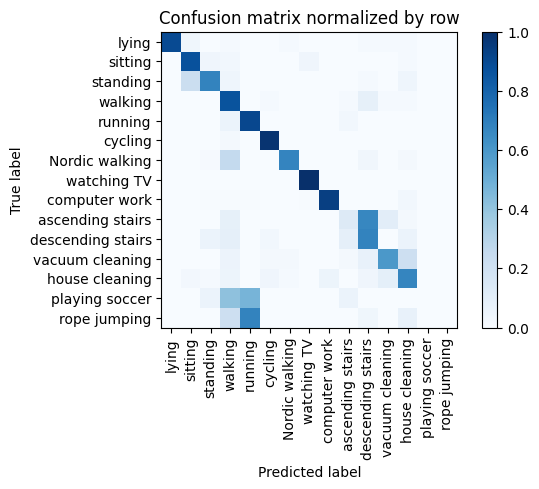

Training Epoch:  80%|████████  | 8/10 [00:31<00:07,  3.95s/it]

Overall accuracy: 0.736



eval: 100%|██████████| 28/28 [00:00<00:00, 65.92batch/s, loss=0.0862]


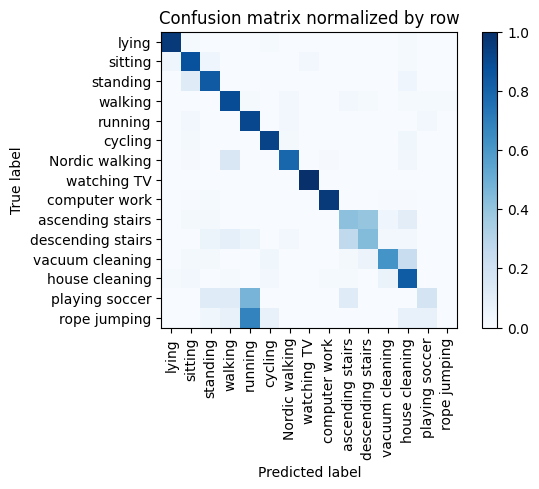

Training Epoch:  90%|█████████ | 9/10 [00:35<00:03,  3.91s/it]

Overall accuracy: 0.792



eval: 100%|██████████| 28/28 [00:00<00:00, 66.79batch/s, loss=0.155]


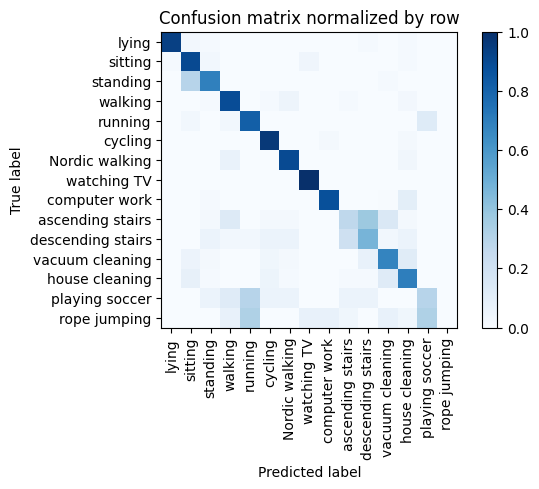

Overall accuracy: 0.765



eval: 100%|██████████| 19/19 [00:00<00:00, 55.39batch/s, loss=0.502]


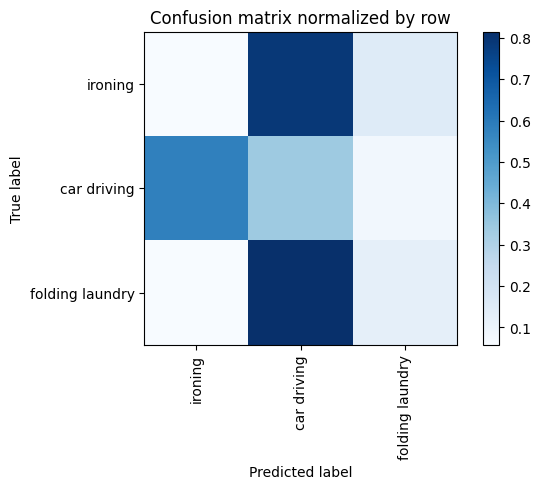

Overall accuracy: 0.117

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        ironing       0.259      0.058      0.095      0.601        360|	 car driving: 0.789,	folding laundry: 0.153,	
folding laundry       0.235      0.126      0.164      0.252        151|	 car driving: 0.815,	ironing: 0.060,	
    car driving       0.069      0.341      0.114      0.147         88|	 ironing: 0.580,	folding laundry: 0.080,	

----------------------------------------------------------------------------------------------------
    avg / total       0.225      0.117      0.115        1.0        599|	      

{'total_accuracy': 0.11686143572621036, 'precision': 0.18749234869245038, 'recall': 0.17502341293732024, 'f1': 0.12443897099069512}
============== Overall Unseen Classes Performance ==============


total_accuracy    0.318637
precision         0.289484
recall            0.321724
f1                0.268123
dtype: float64

In [ ]:
fold_metric_scores = []
for i, cs in enumerate(fold_cls_ids):
    print("="*16, f'Fold-{i}', "="*16)
    print(f'Unseen Classes : {fold_classes[i]}')
    # separate seen/unseen and train/eval 
    data_dict = dataReader.generate(unseen_classes=cs, resampling=True, seen_ratio=config['seen_split'], unseen_ratio=config['unseen_split'], window_size=5.21, window_overlap=1, resample_freq=20)
    all_classes = dataReader.idToLabel
    seen_classes = data_dict['seen_classes']
    unseen_classes = data_dict['unseen_classes']
    # print("seen classes > ", seen_classes)
    # print("unseen classes > ", unseen_classes)
    train_n, seq_len, in_ft = data_dict['train']['X'].shape
    # build train_dt 
    # print(seen_classes)
    train_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=seen_classes)
    train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
    # build seen eval_dt 
    eval_dt = PAMAP2Dataset(data=data_dict['eval-seen']['X'], actions=data_dict['eval-seen']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=seen_classes)
    eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
    # build unseen test_dt
    test_dt = PAMAP2Dataset(data=data_dict['test']['X'], actions=data_dict['test']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=unseen_classes)
    test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
    
    # build model
    model = Model8(in_ft=in_ft, d_model=config['d_model'], num_heads=config['num_heads'], dim_feedforward=config['dim_feedforward'], 
                num_layers=config['num_layers'], ft_size=feat_size, max_len=seq_len, pos_encoding=config['pos_encoding'], activation=config['activation'], norm=config['norm'])
        # model = Model1(feat_dim=in_ft, max_len=seq_len, d_model=config['d_model'], n_heads=config['num_heads'], num_layers=2, dim_feedforward=128, ft_size=feat_size)
    model.to(device)
    # define run parameters 
    optimizer = Adam(model.parameters(), lr=config['lr'])
    loss_module = {'feature': MSELoss(), 'attribute': AttributeLoss()}
    best_acc = 0.0
    # train the model 
    for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):
        train_metrics = train_step(model, train_dl, optimizer, loss_module, 0.7, device, class_names=[all_classes[i] for i in seen_classes], target_feat_met=train_dt.target_feat, phase='train', with_attr=False)
        eval_metrics = eval_step(model, eval_dl, loss_module, 0.7, device, class_names=[all_classes[i] for i in seen_classes],  target_feat_met=eval_dt.target_feat, phase='eval', with_attrs=False, print_report=False)
        # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
        # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
        if eval_metrics['total_accuracy'] > best_acc:
            best_model = deepcopy(model.state_dict())
    
    if best_acc == 0.0:
        best_model = deepcopy(model.state_dict())
    
    # replace by best model 
    model.load_state_dict(best_model)

    # run evaluation on unseen classes
    test_metrics = eval_step(model, test_dl, loss_module, 0.7, device, class_names=[all_classes[i] for i in unseen_classes],  target_feat_met=test_dt.target_feat, phase='eval', with_attrs=False)
    fold_metric_scores.append(test_metrics)
    print(test_metrics)
    print("="*40)
print("="*14, "Overall Unseen Classes Performance", "="*14)
seen_score_df = pd.DataFrame.from_records(fold_metric_scores)
seen_score_df.mean()
    